# Visualization
* 대상지 주요 정보 정리(교통량, 속도, 차로변경 등)
* 시각화
    * 히스토그램 & 바이올린 플롯(집계적)

# Import

In [46]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import warnings
import csv
import os

import math # arctangent; math.atan 사용 목적
import statistics

from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as po

import matplotlib.pyplot  as plt
import seaborn as sns

import pyarrow.parquet as pq

import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib as mpl

from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.text import Annotation

from SSM_base import points

In [47]:
plt.rcParams['font.family'] = 'Times New Roman'

# Load Dataset

In [48]:
working_dir = 'D:/OneDrive/Projects/2023_SSM_Feasibility'

## SSM 계산된 .csv 자료 불러오기
* 합류구간 : `merging_type1_03frm_0.10sec.csv`

In [49]:
folder_name = 'Dataset/03_SSM'

file_list = ['merging_type1_03frm_0.10sec.parquet']

file_path = os.path.join(working_dir, folder_name, file_list[0])
df_0 = pq.read_pandas(file_path).to_pandas()


# df_1 = pd.DataFrame()
    
# for file in tqdm(file_list[1:]):
#     file_path = os.path.join(working_dir, folder_name, file)
#     df = pq.read_pandas(file_path).to_pandas()
#     df_1 = pd.concat([df_1, df])
    
# df_1.reset_index(inplace = True, drop = True)

In [50]:
df_0.head(3)

,veh_id,frm,local_x,local_y,V_len,V_wid,velocity,acc,lane,Time,...,unsafety,MTC,MMTC,TIT,TIT2,TGIT,TIACT,TIDSS,TIDRAC,TIMDRAC
0,2,438,37.28125,7.726562,4.902344,2.064453,92.1875,2.812500,U2,14.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,441,39.81250,7.785156,4.902344,2.064453,91.7500,-1.228516,U2,14.7,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,2,444,42.40625,7.882812,4.902344,2.064453,92.4375,1.814453,U2,14.8,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN


In [51]:
folder_name = 'Documents'
file_name = 'SSM_variables.xlsx'
sheet_name = 'threshold'

threshold_path = os.path.join(working_dir, folder_name, file_name)

threshold_list = np.array(pd.read_excel(threshold_path, sheet_name = sheet_name))

# 주요포인트

In [52]:
def make_cell(local_x):
    """
    Local X (m) 변수값에 따른 셀 번호 지정
        
    """
    
    if pd.isna(local_x) == False:
        cellnum = int(local_x//20 + 1) # 나머지는 버린다.
        cellnum = cellnum * 20
    
        if cellnum < 100:
            cell = '0' + str(cellnum)

        else: # cellnum >= 10인 경우
            cell = str(cellnum)    
            
    else:
        cell = None
        
    return cell

In [53]:
def df_to_plotly(pv):
    return {'z': pv.values.tolist(),
            'y': pv['lane'].tolist(),
            'x': pv.columns.tolist()}

In [54]:
palette_ryb = ['#00b0f0', '#ffff00', '#ff5050'] # 엇갈림구간 프로젝트의 그 삼색팔레트 : 파랑-노랑-빨강
palette_TIT = ['#ffffff', '#ff0000'] # 환색~빨강
#palette_bluewhite = ['#ffffff', '#0054ff'] # 
palette_TTC = ['#ff0000', '#ffffff'] # 빨강~흰색
#palette_whiteblue = ['#0054ff', '#ffffff']

In [55]:
df_0['cell'] = df_0['local_x'].apply(make_cell)

In [56]:
cell_list = list(df_0['cell'].unique())

In [57]:
cell_list

['040', '060', '080', '100', '120', '140', '160', '180', '200', '220', '240']

In [58]:
df_0[df_0['velocity_x'] == df_0['velocity_x'].max()][['delta_local_x', 'delta_local_y', 'velocity', 'velocity_x_before', 'velocity_y_before', 'velocity_x', 'velocity_y']]

,delta_local_x,delta_local_y,velocity,velocity_x_before,velocity_y_before,velocity_x,velocity_y
129282,7.683594,0.241455,106.875,7.597656,0.441895,21.34375,0.670898
129283,7.683594,0.241455,106.875,7.597656,0.441895,21.34375,0.670898
129284,7.683594,0.241455,106.875,7.597656,0.441895,21.34375,0.670898


In [59]:
df_0[['velocity', 'velocity_x']]

,velocity,velocity_x
0,92.1875,NaN
1,91.7500,7.078125
2,92.4375,7.125000
3,92.0625,7.101562
4,92.7500,7.152344
...,...,...
265500,122.8125,9.476562
265501,122.8125,9.476562
265502,119.3125,9.210938
265503,119.3125,9.210938


# 기초통계량

In [60]:
df_0.rename({'time_gap' : 'TimeGap', 'pPET':'TAdv'}, axis = 1, inplace = True)

In [61]:
df_0.head(3)

,veh_id,frm,local_x,local_y,V_len,V_wid,velocity,acc,lane,Time,...,MTC,MMTC,TIT,TIT2,TGIT,TIACT,TIDSS,TIDRAC,TIMDRAC,cell
0,2,438,37.28125,7.726562,4.902344,2.064453,92.1875,2.812500,U2,14.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,040
1,2,441,39.81250,7.785156,4.902344,2.064453,91.7500,-1.228516,U2,14.7,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,040
2,2,444,42.40625,7.882812,4.902344,2.064453,92.4375,1.814453,U2,14.8,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,060


In [62]:
var_list = ['velocity', 'acc']
SSM_list_1 = [ 'TTC', 'MTTC', 'T2', 'TAdv', 'TimeGap', 'ACT']
SSM_list_2 = ['PSD', 'DSS', 'MMTC', 'PICUD', 'MTC']
SSM_list_3 = ['DRAC', 'MDRAC', 'DCIA', 'unsafety']

SSM_list = SSM_list_1 + SSM_list_2 + SSM_list_3

print(len(SSM_list))

15


In [63]:
for df, i in tqdm(zip([df_0][:1], [0][:1])):
    
    total_mean = pd.DataFrame(df[SSM_list].mean()).rename({0 : '전체'}, axis = 1)
    sub_mean = pd.pivot_table(df, columns = ['potential_conflict_type'], values = SSM_list, aggfunc = 'mean') # 소계
    each_mean = pd.pivot_table(df, columns = ['potential_conflict_type', 'LC_CF'], values = SSM_list, aggfunc = 'mean')

    #each_mean.loc[:, ('angled', '전체')] = sub_mean['angled'].astype('float16')
    each_mean.loc[:, ('rear_end', '전체')] = sub_mean['rear_end'].astype('float16')
    each_mean.loc[:, ('side_swipe', '전체')] = sub_mean['side_swipe'].astype('float16')
    each_mean.loc[:, ('전체', '전체')] = total_mean

    total_mean = each_mean.stack().unstack().round(2)
    total_mean = total_mean[['rear_end', 'side_swipe', '전체']]
    
    total_mean.drop([('전체', 'CF'), ('전체', 'LC')], axis = 1, inplace = True)
    
    # 카운트
    
    total_test = pd.DataFrame(df[['veh_id']].count()).rename({0 : '전체'}, axis = 1)
    sub_test = pd.pivot_table(df, columns = ['potential_conflict_type'], values = ['veh_id', 'velocity', 'acc'], aggfunc = {'veh_id' : 'count', 'velocity' : 'mean', 'acc' : 'mean'})
    each_test = pd.pivot_table(df, columns = ['potential_conflict_type', 'LC_CF'], values = ['veh_id', 'velocity', 'acc'], aggfunc = {'veh_id' : 'count', 'velocity' : 'mean', 'acc' : 'mean'})

    #each_test.loc[:, ('angled', '전체')] = sub_test['angled'].astype('float16')
    each_test.loc[:, ('rear_end', '전체')] = sub_test['rear_end'].astype('float16')
    each_test.loc[:, ('side_swipe', '전체')] = sub_test['side_swipe'].astype('float16')
    each_test.loc[:, ('전체', '전체')] = total_test

    total_test = each_test.stack().unstack().round(2)
    #total_test = total_test[['rear_end', 'side_swipe', 'angled', '전체']]

    total_test.drop([('전체', 'CF'), ('전체', 'LC')], axis = 1, inplace = True)
    
    total_mean = pd.concat([total_test, total_mean])
    total_mean = total_mean.round(2)
    total_mean = total_mean.astype('float').round(2).fillna('-')
    
    total_mean = total_mean.reindex(['veh_id', 'velocity', 'acc'] + SSM_list_1 + SSM_list_2 + SSM_list_3)
    
    globals()[f'total_mean_{i}'] = total_mean

1it [00:00,  4.65it/s]


In [64]:
total_mean_0

potential_conflict_type  rear_end                    side_swipe          \
LC_CF                          CF       LC        전체         CF      LC   
veh_id                   12475.00  3461.00  15936.00     1198.0   219.0   
velocity                    94.66    87.54     93.12     109.45   94.88   
acc                         -0.00     0.39      0.08       0.04    0.37   
TTC                       1502.06   838.64   1390.00          -       -   
MTTC                        34.34    31.10     33.59          -       -   
T2                         380.63   230.44    350.00     137.32  411.45   
TAdv                        33.60    39.90     34.97     102.05   18.24   
TimeGap                    314.27   220.57    294.00     538.48  156.91   
ACT                         21.77    18.38     20.94      16.29   16.93   
PSD                        114.78   121.36    116.19          -       -   
DSS                         57.35    53.25     56.69          -       -   
MMTC                        35.41    35.74     35.47          -       -   
PICUD                       67.90    64.32     67.12          -       -   
MTC                        107.91   103.59    106.94          -       -   
DRAC                         0.00     0.00      0.00          -       -   
MDRAC                        0.00     0.00      0.00          -       -   
DCIA                        -0.01     0.00     -0.01          -       -   
unsafety                    -0.01    -0.00     -0.01          -       -   

potential_conflict_type                전체  
LC_CF                        전체        전체  
veh_id                   1417.0  265505.0  
velocity                 107.19         -  
acc                        0.09         -  
TTC                           -   1389.68  
MTTC                          -      33.6  
T2                        159.0    167.52  
TAdv                      89.06     39.39  
TimeGap                   479.5    309.07  
ACT                       16.39      16.9  
PSD                           -    116.22  
DSS                           -     56.68  
MMTC                          -     35.48  
PICUD                         -     67.12  
MTC                           -    106.97  
DRAC                          -       0.0  
MDRAC                         -       0.0  
DCIA                          -     -0.01  
unsafety                      -     -0.01

In [65]:
for df, i in tqdm(zip([df_0][:1], [0][:1])):
    
    total_mean = pd.DataFrame(df[SSM_list].std()).rename({0 : '전체'}, axis = 1)
    sub_mean = pd.pivot_table(df, columns = ['potential_conflict_type'], values = SSM_list, aggfunc = np.std) # 소계
    each_mean = pd.pivot_table(df, columns = ['potential_conflict_type', 'LC_CF'], values = SSM_list, aggfunc = np.std)

    #each_mean.loc[:, ('angled', '전체')] = sub_mean['angled'].astype('float16')
    each_mean.loc[:, ('rear_end', '전체')] = sub_mean['rear_end'].astype('float16')
    each_mean.loc[:, ('side_swipe', '전체')] = sub_mean['side_swipe'].astype('float16')
    each_mean.loc[:, ('전체', '전체')] = total_mean

    total_mean = each_mean.stack().unstack().round(2)
    total_mean = total_mean[['rear_end', 'side_swipe', '전체']]
    
    total_mean.drop([('전체', 'CF'), ('전체', 'LC')], axis = 1, inplace = True)
    
    # 카운트
    
    total_test = pd.DataFrame(df[['veh_id']].count()).rename({0 : '전체'}, axis = 1)
    sub_test = pd.pivot_table(df, columns = ['potential_conflict_type'], values = ['veh_id', 'velocity', 'acc'], aggfunc = {'veh_id' : 'count', 'velocity' : np.std, 'acc' : np.std})
    each_test = pd.pivot_table(df, columns = ['potential_conflict_type', 'LC_CF'], values = ['veh_id', 'velocity', 'acc'], aggfunc = {'veh_id' : 'count', 'velocity' : np.std, 'acc' : np.std})

    #each_test.loc[:, ('angled', '전체')] = sub_test['angled'].astype('float16')
    each_test.loc[:, ('rear_end', '전체')] = sub_test['rear_end'].astype('float16')
    each_test.loc[:, ('side_swipe', '전체')] = sub_test['side_swipe'].astype('float16')
    each_test.loc[:, ('전체', '전체')] = total_test

    total_test = each_test.stack().unstack().round(2)
    #total_test = total_test[['rear_end', 'side_swipe', 'angled', '전체']]

    total_test.drop([('전체', 'CF'), ('전체', 'LC')], axis = 1, inplace = True)
    
    total_mean = pd.concat([total_test, total_mean])
    total_mean = total_mean.round(2)
    total_mean = total_mean.astype('float').round(2).fillna('-')
    
    total_mean = total_mean.reindex(['veh_id', 'velocity', 'acc'] + SSM_list_1 + SSM_list_2 + SSM_list_3)
    
    globals()[f'total_mean_{i}'] = total_mean

1it [00:00,  6.43it/s]


In [66]:
total_mean_0

potential_conflict_type  rear_end                    side_swipe          \
LC_CF                          CF       LC        전체         CF      LC   
veh_id                   12475.00  3461.00  15936.00     1198.0   219.0   
velocity                    14.29    11.48     14.04      11.38    6.19   
acc                          3.23     3.34      3.26       3.18    2.87   
TTC                       4819.45  3486.37   4628.00          -       -   
MTTC                        62.76    37.62     58.03          -       -   
T2                         570.77   413.15    545.50      149.6   255.8   
TAdv                       168.33   273.06    195.88     892.77   36.21   
TimeGap                  11399.61  2217.89  10136.00    4876.04  407.55   
ACT                         57.82    55.83     57.34      23.97   21.64   
PSD                         78.48    89.76     81.12          -       -   
DSS                         33.76    38.41     34.59          -       -   
MMTC                        19.40    22.73     20.17          -       -   
PICUD                       36.04    41.71     37.38          -       -   
MTC                         30.59    37.06     32.16          -       -   
DRAC                         0.00     0.01      0.00          -       -   
MDRAC                        0.00     0.00      0.00          -       -   
DCIA                         1.10     0.26      0.98          -       -   
unsafety                     0.69     0.03      0.61          -       -   

potential_conflict_type                전체  
LC_CF                        전체        전체  
veh_id                   1417.0  265505.0  
velocity                  11.97         -  
acc                        3.13         -  
TTC                           -   4627.24  
MTTC                          -     58.02  
T2                       176.62   1019.78  
TAdv                      821.5    300.88  
TimeGap                  4488.0   9800.25  
ACT                       23.61     42.16  
PSD                           -     81.13  
DSS                           -     34.59  
MMTC                          -     20.18  
PICUD                         -     37.38  
MTC                           -     32.17  
DRAC                          -       0.0  
MDRAC                         -       0.0  
DCIA                          -      0.98  
unsafety                      -      0.61

# 히트맵 또는 산점도

In [67]:
SSM_list_3

['DRAC', 'MDRAC', 'DCIA', 'unsafety']

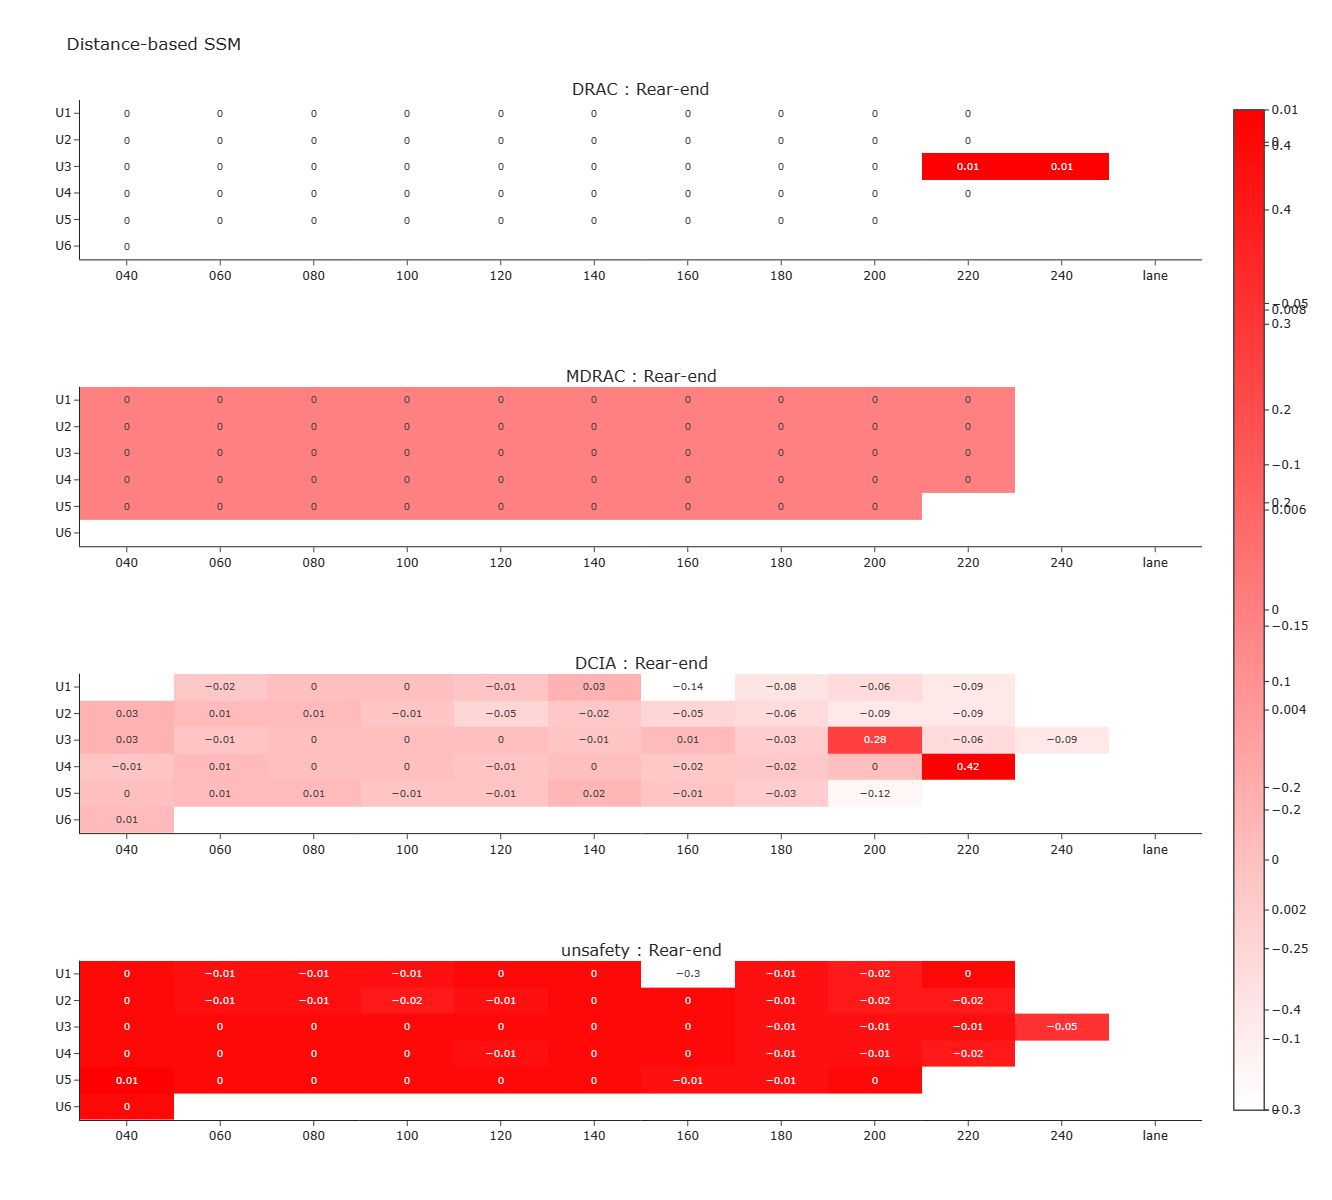

In [68]:
sub_titles = []

for SSM in ['DRAC', 'MDRAC', 'DCIA', 'unsafety']:
    for conflict_type in ['Rear-end']:
        sub_titles.append(f'{SSM} : {conflict_type}')

fig = make_subplots(rows = 4, cols = 1, 
                    subplot_titles = sub_titles)

for conflict_type, j in zip(['rear_end'], [1]): # 각 행별로

    for SSM, i in zip(['DRAC', 'MDRAC', 'DCIA', 'unsafety'], [1, 2, 3, 4]):
        
        sec = df[df['potential_conflict_type'] == conflict_type]
        sec = df.dropna(subset = SSM)
        
        if len(sec) > 0:

            pv_veh = pd.pivot_table(sec,
                       index = 'lane',
                        columns = 'cell',
                        values = [SSM],
                        aggfunc = {SSM : 'mean'})

            pv_veh = pv_veh[SSM]

            for cell in cell_list:
                if cell not in pv_veh.columns:
                    pv_veh[cell] = np.NaN # 만약 셀이 없으면 추가해야 한다.

                else:
                    pass

            pv_veh.reset_index(inplace = True)
            # 컬럼을 셀 번호 이름대로 정렬해준다. 이때 절때 Heatmap의 Categoryascending을 해 주면 안된다는 것이다.
            pv_veh2 = pv_veh[cell_list + ['lane']]

            ax = go.Heatmap(df_to_plotly(pv_veh2.round(2)),
                            colorscale = palette_TIT,
                            texttemplate = '%{z}',
                            textfont = {'size' : 10},
                            showlegend = False,
                            #zmin = 0, zmax = 5
                            )

            fig.add_trace(ax, i, j) # i행 j열에 추가

        else:
            pass
        
fig.update_xaxes(matches = 'x')
fig.update_yaxes(matches = 'y')

fig.update_layout(yaxis = dict(autorange = 'reversed'), 
          height = 1200, width = 600,
          template = 'simple_white',
                 title_text = 'Distance-based SSM')

fig.update(layout_showlegend = False)

fig.show()

# 바이올린

6it [00:00,  9.71it/s]


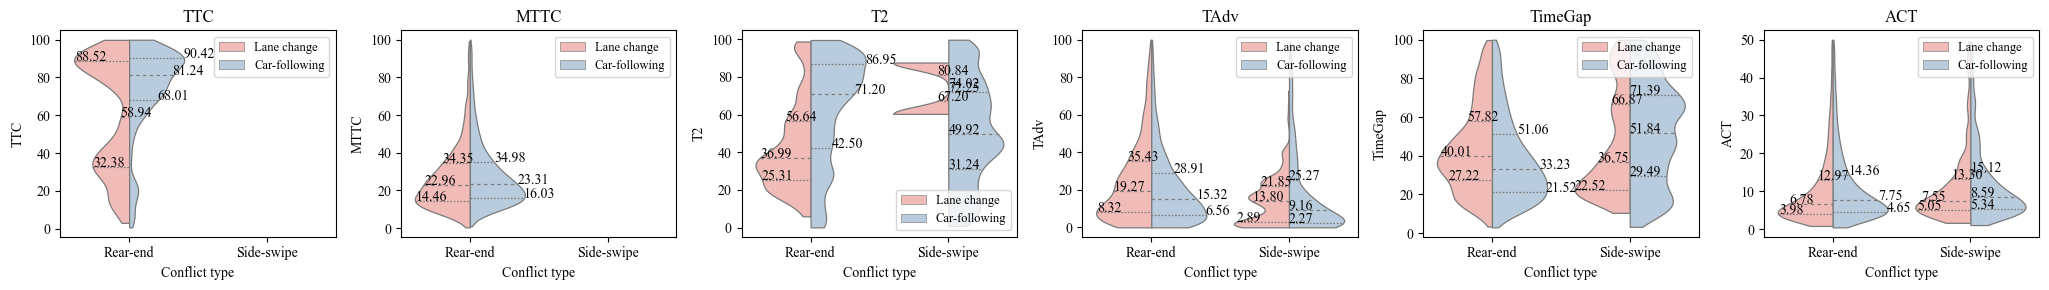

5it [00:00,  9.22it/s]


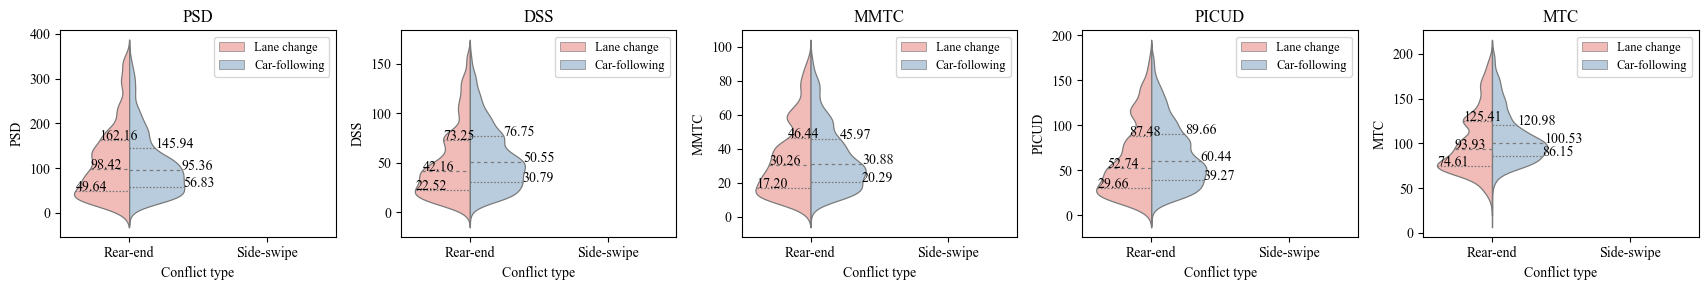

4it [00:00,  8.95it/s]


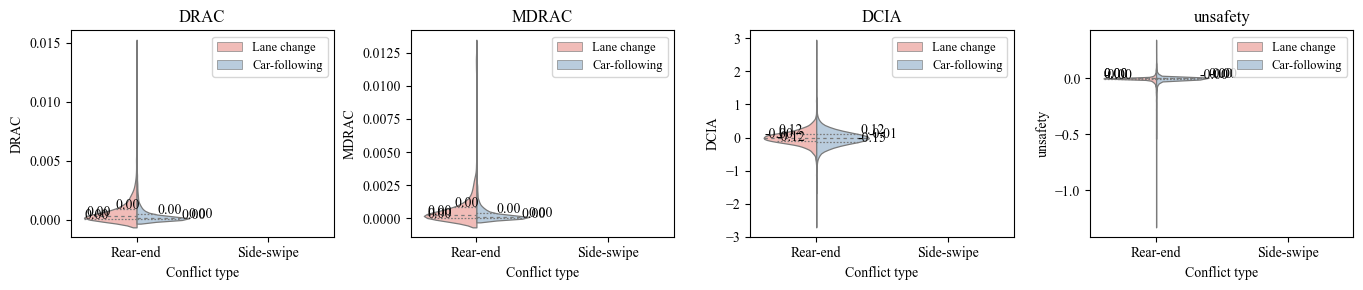

In [69]:
title_list = ['Time-based SSM', 'Distance-based SSM', 'Deceleration-based SSM']

for target_SSM_list, title in zip([SSM_list_1, SSM_list_2, SSM_list_3], title_list):
    
    target_len = 6#len(target_SSM_list)
    
    fig = plt.figure(figsize = (4 * target_len, 3))

    for SSM, i in tqdm(zip(target_SSM_list, range(target_len))):

        fig.add_subplot(1, target_len+1, i+1)
        
        # 임계값 불러오기
        tdx = np.where(threshold_list == SSM)[0][0]
        threshold = threshold_list[tdx][1]

        if SSM == 'ACT':
            upper_bound = 50
            lower_bound = 0
            
            tdf = df_0[(df_0[SSM] >= lower_bound) & (df_0[SSM] <= upper_bound)].dropna(subset = SSM).copy()
        
        elif SSM in SSM_list_1:
            #tdf = df_0[(df_0[SSM] <= 30) & (df_0[SSM] >= 0)].dropna(subset = SSM).copy()
            upper_bound = 100
            lower_bound = 0
            
            tdf = df_0[(df_0[SSM] >= lower_bound) & (df_0[SSM] <= upper_bound)].dropna(subset = SSM).copy()

        else:
            upper_bound = df_0[SSM].mean() + df_0[SSM].std() * 3
            lower_bound = df_0[SSM].mean() - df_0[SSM].std() * 3
            
            tdf = df_0[(df_0[SSM] >= lower_bound) & (df_0[SSM] <= upper_bound)].dropna(subset = SSM).copy()


        tdf['potential_conflict_type'] = tdf['potential_conflict_type'].map({'rear_end': 'Rear-end', 'side_swipe' : 'Side-swipe'})
        tdf['Behavior'] = tdf['LC_CF'].map({'CF': 'Car-following', 'LC' : 'Lane change'})


        if SSM in SSM_list_1:
            
            sec = pd.DataFrame({'potential_conflict_type' : ['Rear-end', 'Side-swipe']})
            tdf = pd.concat([tdf, sec])
            tdf = tdf.sort_values(by = 'LC_CF', ascending = False)

            ax = sns.violinplot(
                data = tdf,
                x = 'potential_conflict_type', y = SSM,
                hue = 'Behavior',
                bw = 0.2,
                linewidth = 0.9,
                scale = 'width',
                split = True,
                palette = "Pastel1",
                cut = 0, inner = 'quart',
                order = ['Rear-end', 'Side-swipe']
            )
            
            # 플롯에 텍스트 달기
            
            for l in ax.lines:
                ax.text(l.get_data()[0][l.get_data()[0].nonzero()][0], l.get_data()[1][0], f'{l.get_data()[1][0]:.2f}')


        elif SSM in SSM_list_2:
            # ax = sns.histplot(
            #     data = tdf,
            #     y = SSM,
            #     hue = 'Behavior', 
            #     #stat = 'density',
            #     kde = True, bins = 50,
            #     linewidth = 0.5, edgecolor = 'white',
            #     palette = "Pastel1",
            #     line_kws = {'linewidth' : 1.5}
            # )
            
            sec = pd.DataFrame({'potential_conflict_type' : ['Rear-end', 'Side-swipe']})
            tdf = pd.concat([tdf, sec])
            
            tdf = tdf.sort_values(by = 'LC_CF', ascending = False)
            
            ax = sns.violinplot(
                data = tdf,
                x = 'potential_conflict_type', y = SSM,
                hue = 'Behavior',
                bw = 0.2,
                linewidth = 0.9,
                scale = 'width',
                split = True,
                palette = "Pastel1",
                inner = 'quart',
                order = ['Rear-end', 'Side-swipe']
            )
            # 플롯에 텍스트 달기
            
            for l in ax.lines:
                ax.text(l.get_data()[0][l.get_data()[0].nonzero()][0], l.get_data()[1][0], f'{l.get_data()[1][0]:.2f}')
            
            
        else:
            temp_dict = {'DRAC' : [0, 10], 'MDRAC' : [0, 5], 'DCIA' : [-10, 10], 'unsafety' : [-10, 10]}
            
            tdf = tdf[(tdf[SSM] >= temp_dict[SSM][0]) & (tdf[SSM] <= temp_dict[SSM][1])]
            
            sec = pd.DataFrame({'potential_conflict_type' : ['Rear-end', 'Side-swipe']})
            tdf = pd.concat([tdf, sec])
            tdf = tdf.sort_values(by = 'LC_CF', ascending = False)
            
            # ax = sns.histplot(
            #     data = tdf,
            #     y = SSM,
            #     hue = 'Behavior', 
            #     #stat = 'density',
            #     kde = True, bins = 50,
            #     linewidth = 0.5, edgecolor = 'white',
            #     palette = "Pastel1",
            #     line_kws = {'linewidth' : 1.5})
            ax = sns.violinplot(
                data = tdf,
                x = 'potential_conflict_type', y = SSM,
                hue = 'Behavior',
                bw = 0.2,
                linewidth = 0.9,
                scale = 'width',
                split = True,
                palette = "Pastel1",
                inner = 'quart',
                order = ['Rear-end', 'Side-swipe']
            )
            
            # 플롯에 텍스트 달기
            
            for l in ax.lines:
                ax.text(l.get_data()[0][l.get_data()[0].nonzero()][0], l.get_data()[1][0], f'{l.get_data()[1][0]:.2f}')
                
            #ax.set_ylim([temp_dict[SSM][0], temp_dict[SSM][1]])

        # 임계값을 설정해 주기
        #plt.axhline(y = threshold, color = 'black', linestyle = '--', linewidth = 0.5, label = f'Threshold {threshold}')

        #ax.legend_.remove()

        # Add title and labels
        plt.title(f'{SSM}')

        if SSM in SSM_list_1:
            #plt.yticks(np.arange(0, 11))
            plt.xlabel('Conflict type')
            plt.ylabel(f'{SSM}')
            plt.legend(fontsize = 9)
            
        else:
            #ax.set_yscale('log')
            #plt.yscale('symlog')
            plt.xlabel('Conflict type')
            plt.ylabel(f'{SSM}')
            plt.legend(fontsize = 9, loc = 'upper right')


    fig.tight_layout()

    ## ----------------------------------------------------------------------
    #이미지 저장하기

    save_file = f'violin_merging_{title}.png'
    save_folder = 'Dataset/04_graph'
    save_path = os.path.join(working_dir, save_folder, save_file)

    plt.savefig(save_path, dpi = 300)
    
    plt.show()

In [70]:
df['DCIA'].max()

44.1141671340848

In [71]:
kur = pd.DataFrame(df_0[SSM_list].kurt()).rename({0 : 'Kurtosis'}, axis = 1)
kur['Skewness'] = pd.DataFrame(df_0[SSM_list].skew()).rename({0 : 'Skewness'}, axis = 1)['Skewness']
kur = kur.round(2)
kur

,Kurtosis,Skewness
TTC,144.05,10.63
MTTC,2054.97,35.49
T2,10021.49,95.00
TAdv,3606.00,50.12
TimeGap,15688.74,122.55
ACT,393.86,15.69
PSD,2.43,1.40
DSS,0.68,0.96
MMTC,0.66,0.96
PICUD,0.01,0.76


# 문제차량 SSM 2-Dimensional Profile 조회

In [91]:
def make_int(x):
    if pd.isna(x) == False:
        return int(x)

    else:
        return None

In [92]:
df['LV_ID'] = df['LV_ID'].apply(make_int)

In [105]:
df[(df['veh_id'] == 1542) & (df['LV_ID'] == 1544)]

,veh_id,frm,local_x,local_y,V_len,V_wid,velocity,acc,lane,Time,...,MTC,MMTC,TIT,TIT2,TGIT,TIACT,TIDSS,TIDRAC,TIMDRAC,cell
255327,1542,25722,224.125,10.640625,7.609375,2.193359,98.0000,-3.708984,U2,857.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240
255328,1542,25722,224.125,10.640625,7.609375,2.193359,98.0000,-3.708984,U2,857.4,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,240
255329,1542,25722,224.125,10.640625,7.609375,2.193359,98.0000,-3.708984,U2,857.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240
255330,1542,25722,224.125,10.640625,7.609375,2.193359,98.0000,-3.708984,U2,857.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240
255331,1542,25722,224.125,10.640625,7.609375,2.193359,98.0000,-3.708984,U2,857.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240
255332,1542,25725,226.750,10.679688,7.609375,2.193359,98.1250,0.299805,U2,857.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240
255333,1542,25725,226.750,10.679688,7.609375,2.193359,98.1250,0.299805,U2,857.5,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,240
255334,1542,25725,226.750,10.679688,7.609375,2.193359,98.1250,0.299805,U2,857.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240
255335,1542,25725,226.750,10.679688,7.609375,2.193359,98.1250,0.299805,U2,857.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240
255336,1542,25725,226.750,10.679688,7.609375,2.193359,98.1250,0.299805,U2,857.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240


In [108]:
df[(df['veh_id'] == 1544) & (df['LV_ID'] == 1542)]

,veh_id,frm,local_x,local_y,V_len,V_wid,velocity,acc,lane,Time,...,MTC,MMTC,TIT,TIT2,TGIT,TIACT,TIDSS,TIDRAC,TIMDRAC,cell
255535,1544,25572,47.12500,6.910156,4.902344,2.193359,131.2500,0.254150,U2,852.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,060
255536,1544,25572,47.12500,6.910156,4.902344,2.193359,131.2500,0.254150,U2,852.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,060
255537,1544,25572,47.12500,6.910156,4.902344,2.193359,131.2500,0.254150,U2,852.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,060
255538,1544,25575,50.78125,6.964844,4.902344,2.193359,132.1250,2.285156,U2,852.5,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,060
255539,1544,25575,50.78125,6.964844,4.902344,2.193359,132.1250,2.285156,U2,852.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255620,1544,25656,146.62500,8.867188,4.902344,2.193359,124.9375,0.996582,U2,855.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160
255621,1544,25656,146.62500,8.867188,4.902344,2.193359,124.9375,0.996582,U2,855.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160
255622,1544,25659,150.12500,9.070312,4.902344,2.193359,125.2500,0.882812,U2,855.3,...,55.322852,5.852559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160
255623,1544,25659,150.12500,9.070312,4.902344,2.193359,125.2500,0.882812,U2,855.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160


3it [00:02,  1.14it/s]


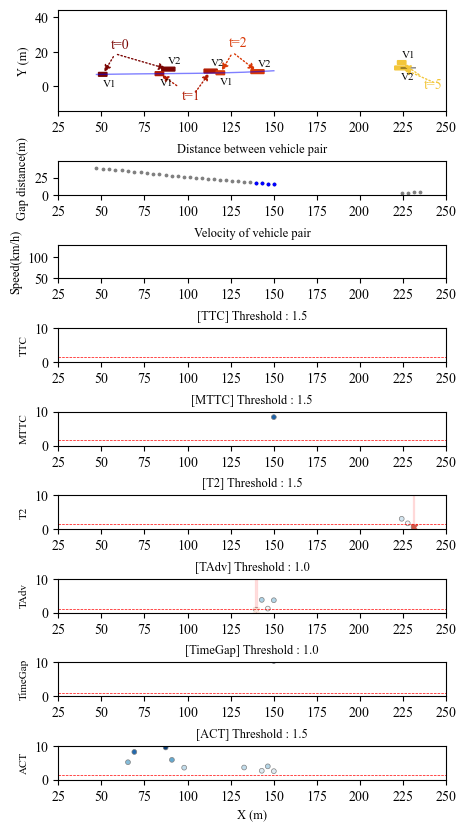

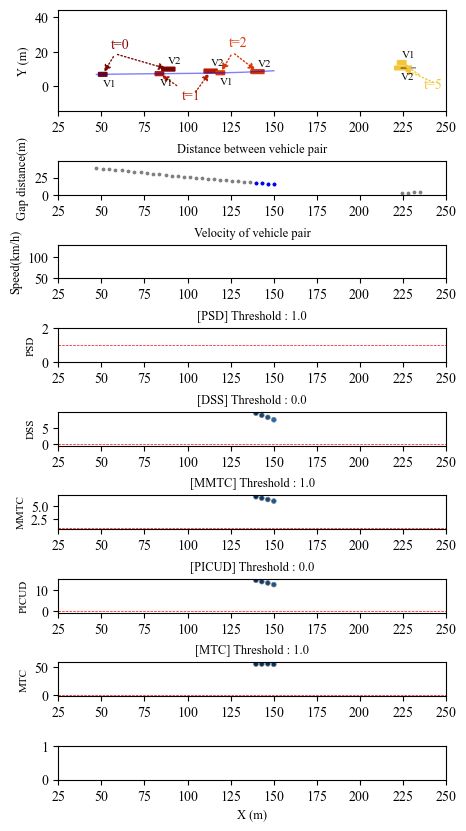

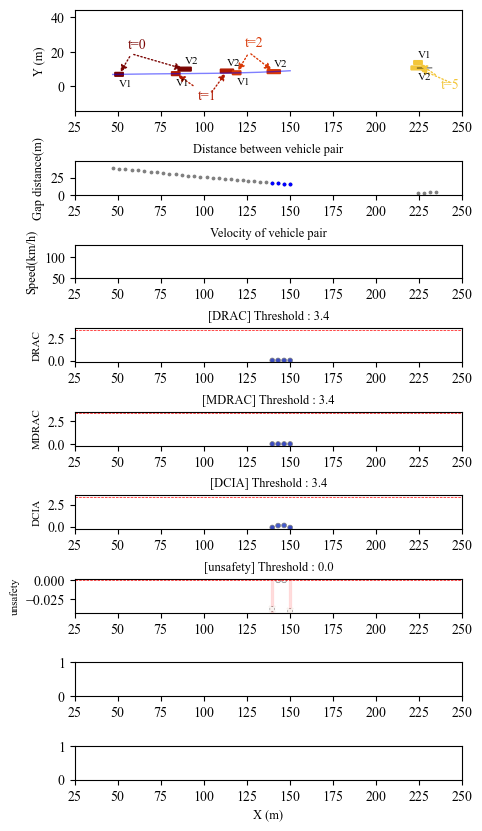

In [109]:
df = df_0
scatter_size = 12

#Vehicle_ID, LV_ID = '1631', '1629'
#Vehicle_ID, LV_ID = '126', '125'
Vehicle_ID, LV_ID = 1544, 1542
#Vehicle_ID, LV_ID = '654', '652'

for target_SSM_list, title in tqdm(zip([SSM_list_1, SSM_list_2, SSM_list_3], ['Time-based SSM', 'Distance-based SSM', 'Deceleration-based SSM'])):
    
    fig = plt.figure(figsize = (5, 10))
    row_num = len(SSM_list_1)+3

    if target_SSM_list != SSM_list_3:

        gs = fig.add_gridspec(row_num, 1, height_ratios = (3, 1, 1, 1, 1, 1, 1, 1, 1), hspace = 1.2) # 5행 1열의 그리드 생성

    else:
        gs = fig.add_gridspec(row_num, 1, height_ratios = (3, 1, 1, 1, 1, 1, 1, 1, 1), hspace = 1.2) # 5행 1열의 그리드 생성

    # 대상 차량 쌍을 필터링하여, 프레임별로 정렬하기
    sec1 = df[(df['veh_id'] == Vehicle_ID) & (df['LV_ID'] == LV_ID)]
    sec2 = df[(df['veh_id'] == LV_ID) & (df['LV_ID'] == Vehicle_ID)]

    # TV, LV가 역전된 sec2 DF의 경우, 컬럼이름을 바꾸어주어야 한다.
    col_list = ['local_x', 'local_y', 'velocity', 'acc', 'lane', 'Time', 'local_x_before',
           'local_y_before', 'delta_local_x', 'delta_local_y', 'velocity_x',
           'velocity_y', 'velocity_x_before', 'velocity_y_before',
           'delta_velocity_x', 'delta_velocity_y', 'acc_x', 'acc_y', 'lane_past',
           'Lane_record', 'Lane_record_split', 'Lane_00', 'Lane_99', 'Lane_change',
           'Lane_leave', 'Lane_change_direction']

    for col in col_list:
        sec2.rename({col:f'LV2_{col}'}, axis = 1, inplace = True)
        sec2.rename({f'LV_{col}' : col}, axis = 1, inplace = True)
        sec2.rename({f'LV2_{col}':f'LV_{col}'}, axis = 1, inplace = True)

    sec2.rename({'V_len' : 'LV_len', 'V_wid' : 'LV_wid', 'LV_wid' : 'V_wid', 'LV_len' : 'V_len'}, axis = 1, inplace = True)

    sample = pd.concat([sec1, sec2])
    #sample = sample.sort_values(by = ['frm']).drop_duplicates(['frm'])
    sample = sample.reset_index(drop = True)

    ## 대상차량 궤적 표시
    V_x = np.array(sample['local_x'])
    V_y = np.array(sample['local_y'])
    V_time = np.array(sample['Time'])

    V_vx = np.array(sample['velocity_x'])
    V_vy = np.array(sample['velocity_y'])
    
    test = px.colors.sequential.Turbo[::-1]
    gradient_list = np.array(test)

    ## 선행차량 궤적 표시
    LV_x = np.array(sample['LV_local_x'])
    LV_y = np.array(sample['LV_local_y'])

    LV_vx = np.array(sample['LV_velocity_x'])
    LV_vy = np.array(sample['LV_velocity_y'])


    # 차량 사이즈
    V_len = sample[sample['veh_id'] == Vehicle_ID]['V_len'].iloc[0]
    V_wid = sample[sample['veh_id'] == Vehicle_ID]['V_wid'].iloc[0]
    LV_len = sample[sample['LV_ID'] == LV_ID]['LV_len'].iloc[0]
    LV_wid = sample[sample['LV_ID'] == LV_ID]['LV_wid'].iloc[0]

    # 서브플롯 생성
    for row in range(0, row_num):
        globals()[f'ax_{row}_0'] = fig.add_subplot(gs[row, 0]) # row행 col열에 서브플롯 생성
        globals()[f'ax_{row}_0'].set_xlim(25, 250) # 가로축 통일

    # 첫 플롯에만 백그라운드 궤적 생성하기

    globals()[f'ax_0_0'].plot(V_x, V_y, c = 'blue', linewidth = 1, alpha = 0.5)
    globals()[f'ax_0_0'].plot(LV_x, LV_y, c = 'black', linewidth = 1, alpha = 0.5)

    # globals()[f'ax_0_0'].scatter(V_x, V_y, c = 'lightgray', marker = 'o', s = scatter_size/4)
    # globals()[f'ax_0_0'].scatter(LV_x, LV_y, c = 'lightgray', marker = '^', s = scatter_size/4)

    globals()[f'ax_0_0'].axis('equal')
    globals()[f'ax_0_0'].set_xlim(25, 250) # 가로축 통일
    globals()[f'ax_0_0'].set_ylim(0, 30)
    globals()[f'ax_0_0'].set_ylabel('Y (m)', size = 9)


    # 가장 위 플롯에만 1초 간격으로 연결하기, 차량의 상대적 위치 표시하기

    V_time = np.array(sample['Time'])
    V_time_label = np.array((sample['Time'] - np.nanmin(V_time)).round(2))

    time_min = math.ceil(np.nanmin(V_time_label))
    time_max = math.floor(np.nanmax(V_time_label))
    
    time_list = [0.1] + list(range(1, time_max+1)) #  + [np.nanmax(V_time_label)]

    for i, ikk in zip(time_list, range(len(time_list))):

        # t == i일때의 인덱스 반환 
        if len(np.where(V_time_label == i)[0]) > 0:
            idx = np.where(V_time_label == i)[0][0]
            #print(np.where(V_time_label == i)[0], i, idx)
            #print(i, idx)
            gradient = gradient_list[ikk]
            #lobals()[f'ax_0_0'].plot([V_x[idx], LV_x[idx]], [V_y[idx], LV_y[idx]], c = gradient, linewidth = 0.5)

            local_x = V_x[idx]
            LV_local_x = LV_x[idx]

            local_y = V_y[idx]
            LV_local_y = LV_y[idx]

            V_velocity_x = V_vx[idx]
            V_velocity_y = V_vy[idx]

            LV_velocity_x = LV_vx[idx]
            LV_velocity_y = LV_vy[idx]
            
            
            
            #print(local_y, LV_local_y, local_x, LV_local_x)
            # 차량의 상대적 위치관계를 직선으로 연결하고, t = x 를 화살표로 표시하기

            if round(i)%2 == 0 : # i가 짝수이면 위에 notation
                globals()[f'ax_0_0'].annotate(f't={round(i)}', 
                            xy = (V_x[idx], V_y[idx]), 
                            xytext = (V_x[idx]+5, V_y[idx]+15), color = gradient,
                            arrowprops = dict(facecolor = gradient, arrowstyle = '-|>', linestyle = ':', edgecolor = gradient))

                globals()[f'ax_0_0'].annotate(f'', 
                            xy = (LV_x[idx], LV_y[idx]), 
                            xytext = (V_x[idx]+7, V_y[idx]+12), color = gradient,
                            arrowprops = dict(facecolor = gradient, arrowstyle = '-|>', linestyle = ':', edgecolor = gradient))

            else: #i가 홀수이면
                globals()[f'ax_0_0'].annotate(f't={round(i)}', 
                            xy = (V_x[idx], V_y[idx]), 
                            xytext = (V_x[idx]+13, V_y[idx]-15), color = gradient,
                            arrowprops = dict(facecolor = gradient, arrowstyle = '-|>', linestyle = ':', edgecolor = gradient))

                globals()[f'ax_0_0'].annotate(f'', 
                            xy = (LV_x[idx], LV_y[idx]), 
                            xytext = (V_x[idx]+20, V_y[idx]-12), color = gradient,
                            arrowprops = dict(facecolor = gradient, arrowstyle = '-|>', linestyle = ':', edgecolor = gradient))


            ## 각 t = x 점에서 차량의 위치를 선으로 그리기

            #print(i, idx, V_velocity_x, LV_velocity_x)

            if pd.isna(V_velocity_x) == False and pd.isna(LV_velocity_x) == False:
                
                r1 = patches.Rectangle((local_x-1/2*V_len, local_y-1/2*V_wid), V_len, V_wid, color = gradient, alpha = 1) # TV 위치
                r2 = patches.Rectangle((LV_local_x-1/2*LV_len, LV_local_y-1/2*V_wid), LV_len, LV_wid, color = gradient,  alpha = 1)
                
                rotate_angle_1 = math.atan(V_velocity_y/V_velocity_x)
                rotate_angle_2 = math.atan(LV_velocity_y/LV_velocity_x)
                
                if V_velocity_y >= 0:
                    sign_1 = 1
                else:
                    sign_1 = -1
                    
                if LV_velocity_y >= 0:
                    sign_2 = 1
                else:
                    sign_2 = -1
                
                t1 = mpl.transforms.Affine2D().rotate_deg(sign_1 * rotate_angle_1) + globals()[f'ax_0_0'].transData
                r1.set_transform(t1)
                
                t2 = mpl.transforms.Affine2D().rotate_deg(sign_2 * rotate_angle_2) + globals()[f'ax_0_0'].transData
                r2.set_transform(t2)
                
                globals()[f'ax_0_0'].add_patch(r1)
                globals()[f'ax_0_0'].add_patch(r2)
                
                if local_y > LV_local_y: # 만약 TV가 LV보다 위에 있으면                
                    globals()[f'ax_0_0'].text(local_x, local_y+3, 'V1', color = 'black', size = 8)
                    globals()[f'ax_0_0'].text(LV_local_x, LV_local_y-7, 'V2', color = 'black', size = 8)
                    
                else:
                    globals()[f'ax_0_0'].text(local_x, local_y-7, 'V1', color = 'black', size = 8)
                    globals()[f'ax_0_0'].text(LV_local_x, LV_local_y+3, 'V2', color = 'black', size = 8)

            else:
                pass
        
        else:
            pass

    ## -----------------------------------------------------------------------------------------------

    # 두 번째 플롯에 상대거리(D), 상충유형, LC-CF 추가하기
    D = abs(sample['D'])
    globals()[f'ax_1_0'].set_title(f'Distance between vehicle pair', size = 9)
    globals()[f'ax_1_0'].scatter(V_x, D, marker = 'o', color = 'gray', s = scatter_size/4)
    globals()[f'ax_1_0'].set_ylabel('Gap distance(m)', size = 9)
    
    for conftype, clr in zip(['rear_end', 'side_swipe', 'angled'], ['blue', 'red', 'orange']):
        tick = sample[(sample['potential_conflict_type'] == conftype)]
        tick_D = tick['D']
        tick_x = tick['local_x']
        globals()[f'ax_1_0'].scatter(tick_x, tick_D, marker = 'o', color = clr, s = scatter_size/4, label = conftype)
        #globals()[f'ax_1_0'].legend(loc = 'upper right')
    
    #globals()[f'ax_1_0'].legend(loc = 'upper right', fontsize = 8)
    globals()[f'ax_1_0'].set_ylim(0, np.nanmax(D)+10) # 세로축 통일
    
    
    
    ##-----------------------------------------------------------------------------------------------
    # 세번째 플롯에 두 차량의 속도와 LC-CF를 표기하기
    
    globals()[f'ax_2_0'].set_title(f'Velocity of vehicle pair', size = 9)
    
    for LC_CF, clr in zip(['CF', 'LC'], ['blue', 'skyblue']): # LC_CF에 따라서 다른 마커모양을 적용하시오
        tick = sample[sample['LC_CF'] == LC_CF]
        tick_V_x = tick['local_x']
        tick_V_v = tick['velocity_x']
    
        globals()[f'ax_2_0'].scatter(tick_V_x, tick_V_v, marker = 'x', color = clr, s = scatter_size/2, label = 'V1')
        
    for LC_CF, clr in zip(['CF', 'LC'], ['gray', 'lightgray']): # LC_CF에 따라서 다른 마커모양을 적용하시오
        tick = sample[sample['LV_LC_CF'] == LC_CF]
        tick_LV_x = tick['LV_local_x']
        tick_LV_v = tick['LV_velocity_x']
    
        globals()[f'ax_2_0'].scatter(tick_LV_x, tick_LV_v, marker = 'o', color = clr, s = scatter_size/2, label = 'V2')
    
    globals()[f'ax_2_0'].set_ylim(50, 130) # 가로축 통일
    globals()[f'ax_2_0'].set_ylabel('Speed(km/h)', size = 9)
    
    
    ## ------------------------------------------------------------------------------------------------
    # 각 SSM을 그리기 : 각 행별로

    ## Time-based

    for SSM, row in zip(target_SSM_list, range(0, row_num)): # Time-based 면 1행에 집어넣는다

        tdx = np.where(threshold_list == SSM)[0][0]
        threshold = threshold_list[tdx][1]

        V_ssm = np.array(sample[SSM])
        
        if len(V_ssm[np.isnan(V_ssm) == False]) > 0: # SSM 값이 최소 1개 이상 존재하면


            # SSM 값에 따른 색상스케일 설정
            ## 임계값이 존재하고, 값이 0 이상이며, 임계값보다 작을수록 위험할 시
            if SSM in ['TTC', 'T2', 'MTTC', 'ACT', 'TAdv', 'TimeGap']:
                divnorm = colors.TwoSlopeNorm(vmin = 0, vcenter = threshold, vmax = 10)
                globals()[f'ax_{row+3}_0'].set_title(f'[{SSM}] Threshold : {threshold}', size = 9) # , The lower the value, the higher the risk
                #globals()[f'ax_{row+3}_0'].axhspan(0, threshold, alpha = 0.1, color = 'gray')

                globals()[f'ax_{row+3}_0'].scatter(V_x, V_ssm, c = V_ssm, 
                marker = 'o', edgecolor = 'gray', linewidth = 0.5,  s = scatter_size,
                       cmap = 'RdBu', norm = divnorm,
                       label = 'Following Vehicle')
                
                globals()[f'ax_{row+3}_0'].set_ylim([0, 10])


                # 임계값 아래인 지점에는 붉은색 X표시를 하기
                danger_V_x = np.array(sample[sample[SSM] < threshold]['local_x'])
                danger_V_ssm = np.array(sample[sample[SSM] < threshold][SSM])
                
                for dvx in danger_V_x:
                    globals()[f'ax_{row+3}_0'].axvspan(dvx-0.5, dvx+0.5, color = 'red', alpha = 0.1)
                    
                globals()[f'ax_{row+3}_0'].scatter(danger_V_x, danger_V_ssm, marker = 'x', c = danger_V_ssm, cmap = 'RdBu', norm = divnorm, s = 20, label = 'Danger')
                
                
            elif SSM in ['PSD']:
                divnorm = colors.TwoSlopeNorm(vmin = 0, vcenter = threshold, vmax = 2)
                globals()[f'ax_{row+3}_0'].set_title(f'[{SSM}] Threshold : {threshold}', size = 9) # , The lower the value, the higher the risk
                #globals()[f'ax_{row+3}_0'].axhspan(0, threshold, alpha = 0.1, color = 'gray')

                globals()[f'ax_{row+3}_0'].scatter(V_x, V_ssm, c = V_ssm, 
                marker = 'o', edgecolor = 'gray', linewidth = 0.5,  s = scatter_size,
                       cmap = 'RdBu', norm = divnorm,
                       label = 'Following Vehicle')
                
                globals()[f'ax_{row+3}_0'].set_ylim([0, 2])


                # 임계값 아래인 지점에는 붉은색 X표시를 하기
                danger_V_x = np.array(sample[sample[SSM] < threshold]['local_x'])
                danger_V_ssm = np.array(sample[sample[SSM] < threshold][SSM])
                
                for dvx in danger_V_x:
                    globals()[f'ax_{row+3}_0'].axvspan(dvx-0.5, dvx+0.5, color = 'red', alpha = 0.1)
                    
                globals()[f'ax_{row+3}_0'].scatter(danger_V_x, danger_V_ssm, marker = 'x', c = danger_V_ssm, cmap = 'RdBu', norm = divnorm, s = 20, label = 'Danger')
                

            ## 임계값이 있고, 바닥이 없으며, 임계값보다 작을수록 위험할 시
            elif SSM in ['PICUD', 'DSS', 'MTC', 'MMTC', 'unsafety']:
                divnorm = colors.TwoSlopeNorm(vmin = np.nanmin([-1, np.nanmin(V_ssm)]), vcenter = threshold, vmax = np.nanmax([2, np.nanmax(V_ssm)]))
                globals()[f'ax_{row+3}_0'].set_title(f'[{SSM}] Threshold : {threshold}', size = 9) # , The lower the value, the higher the risk
                #globals()[f'ax_{row+3}_0'].axhspan(threshold, np.min([-1, np.nanmin(V_ssm)]), alpha = 0.1, color = 'gray')

                globals()[f'ax_{row+3}_0'].scatter(V_x, V_ssm, c = V_ssm, 
                marker = 'o', edgecolor = 'gray', linewidth = 0.5,  s = scatter_size,
                       cmap = 'RdBu', norm = divnorm,
                       label = 'Following Vehicle')

                    
                # 임계값 아래인 지점에는 붉은색 X표시를 하기
                danger_V_x = np.array(sample[sample[SSM] < threshold]['local_x'])
                danger_V_ssm = np.array(sample[sample[SSM] < threshold][SSM])
                
                for dvx in danger_V_x:
                    globals()[f'ax_{row+3}_0'].axvspan(dvx-0.5, dvx+0.5, color = 'red', alpha = 0.1)                

                globals()[f'ax_{row+3}_0'].scatter(danger_V_x, danger_V_ssm, marker = 'x', c = danger_V_ssm, cmap = 'RdBu', norm = divnorm, s = 20, label = 'Danger')
                

            ## 임계값이 있고, 이보다 클수록 위험할 경우
            elif SSM in ['DRAC', 'MDRAC', 'DCIA']:
                divnorm = colors.TwoSlopeNorm(vmin = np.nanmin([0, np.nanmin(V_ssm)]), vcenter = threshold, vmax = threshold + 5)
                globals()[f'ax_{row+3}_0'].set_title(f'[{SSM}] Threshold : {threshold}', size = 9) #, The higher the value, the higher the risk'
                #globals()[f'ax_{row+3}_0'].axhspan(threshold, np.nanmax([np.nanmax(V_ssm), 5]), alpha = 0.1, color = 'gray')

                globals()[f'ax_{row+3}_0'].scatter(V_x, V_ssm, c = V_ssm, 
                marker = 'o', edgecolor = 'gray', linewidth = 0.5,  s = scatter_size,
                       cmap = 'coolwarm', norm = divnorm,
                       label = 'Following Vehicle')

                    
                # 임계값 위인 지점에는 붉은색 X표시를 하기
                danger_V_x = np.array(sample[sample[SSM] > threshold]['local_x'])
                danger_V_ssm = np.array(sample[sample[SSM] > threshold][SSM])
                
                for dvx in danger_V_x:
                    globals()[f'ax_{row+3}_0'].axvspan(dvx-0.5, dvx+0.5, color = 'red', alpha = 0.1)    
                    
                globals()[f'ax_{row+3}_0'].scatter(danger_V_x, danger_V_ssm, marker = 'x', c = danger_V_ssm, cmap = 'coolwarm', norm = divnorm, s = 20, label = 'Danger')


            ## 그 외
            else:
                divnorm = colors.TwoSlopeNorm(vmin = np.nanmin([0, np.nanmin(V_ssm)]), vcenter = threshold, vmax = threshold + 5)

                globals()[f'ax_{row+3}_0'].scatter(V_x, V_ssm, c = V_ssm, 
                marker = 'o', edgecolor = 'gray', linewidth = 0.5,  s = scatter_size,
                       cmap = 'turbo', norm = divnorm,
                       label = 'Following Vehicle')


            # 플롯에 축 설정
            globals()[f'ax_{row+3}_0'].set_ylabel(SSM, size = 8)

            # 플롯에 임계값을 가로선으로 그려준다
            globals()[f'ax_{row+3}_0'].axhline(y = threshold, color = 'red', linestyle = '--', linewidth = 0.5, label = f'Threshold = {threshold}')
            #globals()[f'ax_{row+1}_0'].text(30, np.nanmean([np.nanmin([0, np.nanmin(V_ssm)]), np.nanmax(V_ssm)]), f'Threshold : {threshold}', color = 'red', size = 8)
            
            #globals()[f'ax_{row+1}_0'].legend([], [f'Threshold : {threshold}'],loc = 'upper right', fontsize = 8)
            
        else: # SSM 값이 하나도 없으면
            globals()[f'ax_{row+3}_0'].set_title(f'[{SSM}] Threshold : {threshold}', size = 9) #, The higher the value, the higher the risk'
            globals()[f'ax_{row+3}_0'].set_ylabel(SSM, size = 8)
            globals()[f'ax_{row+3}_0'].text(130, 0.4, 'None', color = 'black', size = 8)


    # 가장 아래에 X(m) 라고 거리 표시
    globals()[f'ax_{row_num-1}_0'].set_xlabel('X (m)', size = 9)
    
    
    
    ## ----------------------------------------------------------------------
    #이미지 저장하기
    
    save_file = f'merging_{Vehicle_ID}_{LV_ID}_{title}.png'
    save_folder = 'Dataset/04_graph'
    save_path = os.path.join(working_dir, save_folder, save_file)
    
    plt.savefig(save_path, dpi = 300)